In [1]:
import pandas as pd
import yfinance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr

# make the necessary imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
yf.pdr_override()

In [37]:
tickers =  ['WTI','EOG','VLO','XOM','SWN']

start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2022, 10, 1)

df = pdr.get_data_yahoo(tickers, start, end)['Close']
descriptive_statistics=df.describe()

[*********************100%***********************]  5 of 5 completed


In [38]:
descriptive_statistics.to_latex()

C:\Users\ems\AppData\Local\Temp\ipykernel_10612\2921558718.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptive_statistics.to_latex()


'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &          EOG &          SWN &          VLO &          WTI &          XOM \\\\\n\\midrule\ncount &  1447.000000 &  1447.000000 &  1447.000000 &  1447.000000 &  1447.000000 \\\\\nmean  &    88.317927 &     4.668176 &    81.110048 &     4.104485 &    70.023186 \\\\\nstd   &    24.580112 &     1.845351 &    20.259503 &     1.680137 &    15.949422 \\\\\nmin   &    29.760000 &     1.260000 &    32.619999 &     1.090000 &    31.450001 \\\\\n25\\%   &    72.950001 &     3.150000 &    66.575001 &     2.770000 &    59.850000 \\\\\n50\\%   &    91.760002 &     4.660000 &    79.379997 &     4.060000 &    75.580002 \\\\\n75\\%   &   105.380001 &     5.605000 &    92.884998 &     4.985000 &    81.830002 \\\\\nmax   &   145.929993 &    10.320000 &   145.080002 &     9.840000 &   104.589996 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [39]:
train_close, test_close = train_test_split(df, test_size=0.1, shuffle=False)

In [40]:
#Define function to find cointegrated pairs from chosen tickers
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs


Text(0.5, 1.0, 'Assets Correlation Matrix')

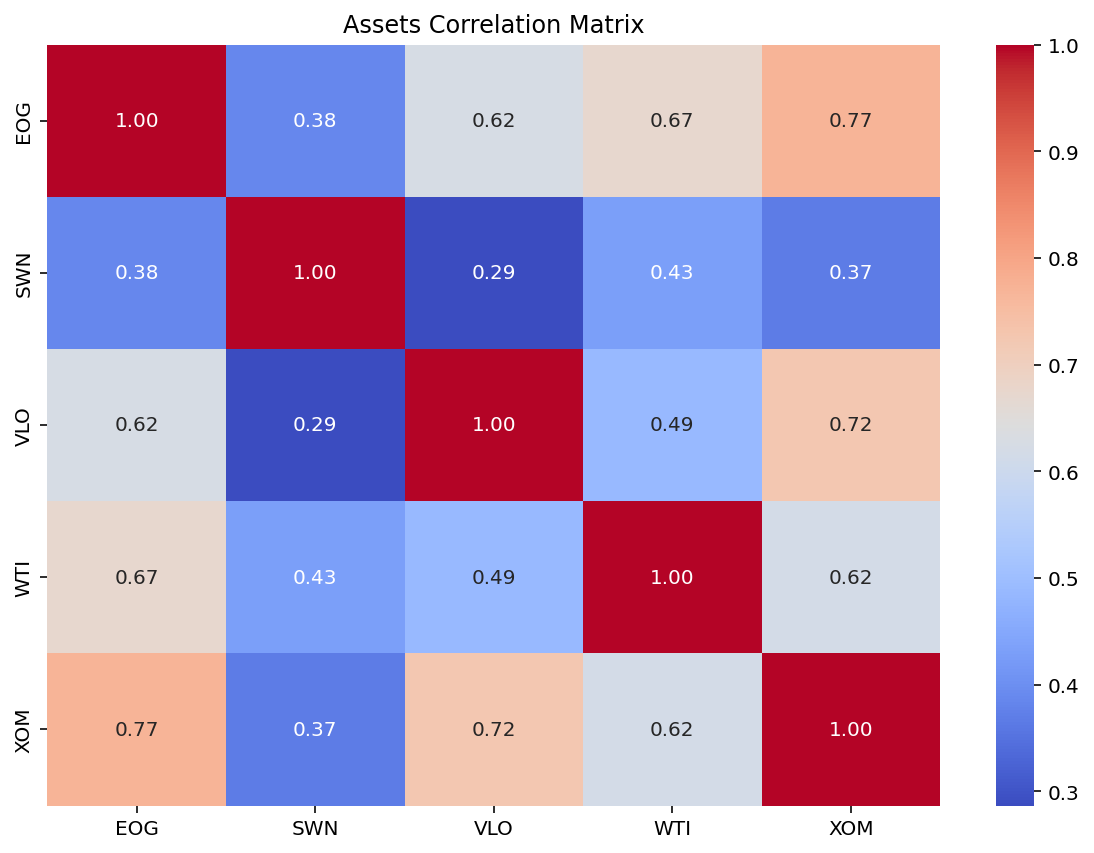

In [41]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
#plt.savefig('images/chart1', dpi=300)

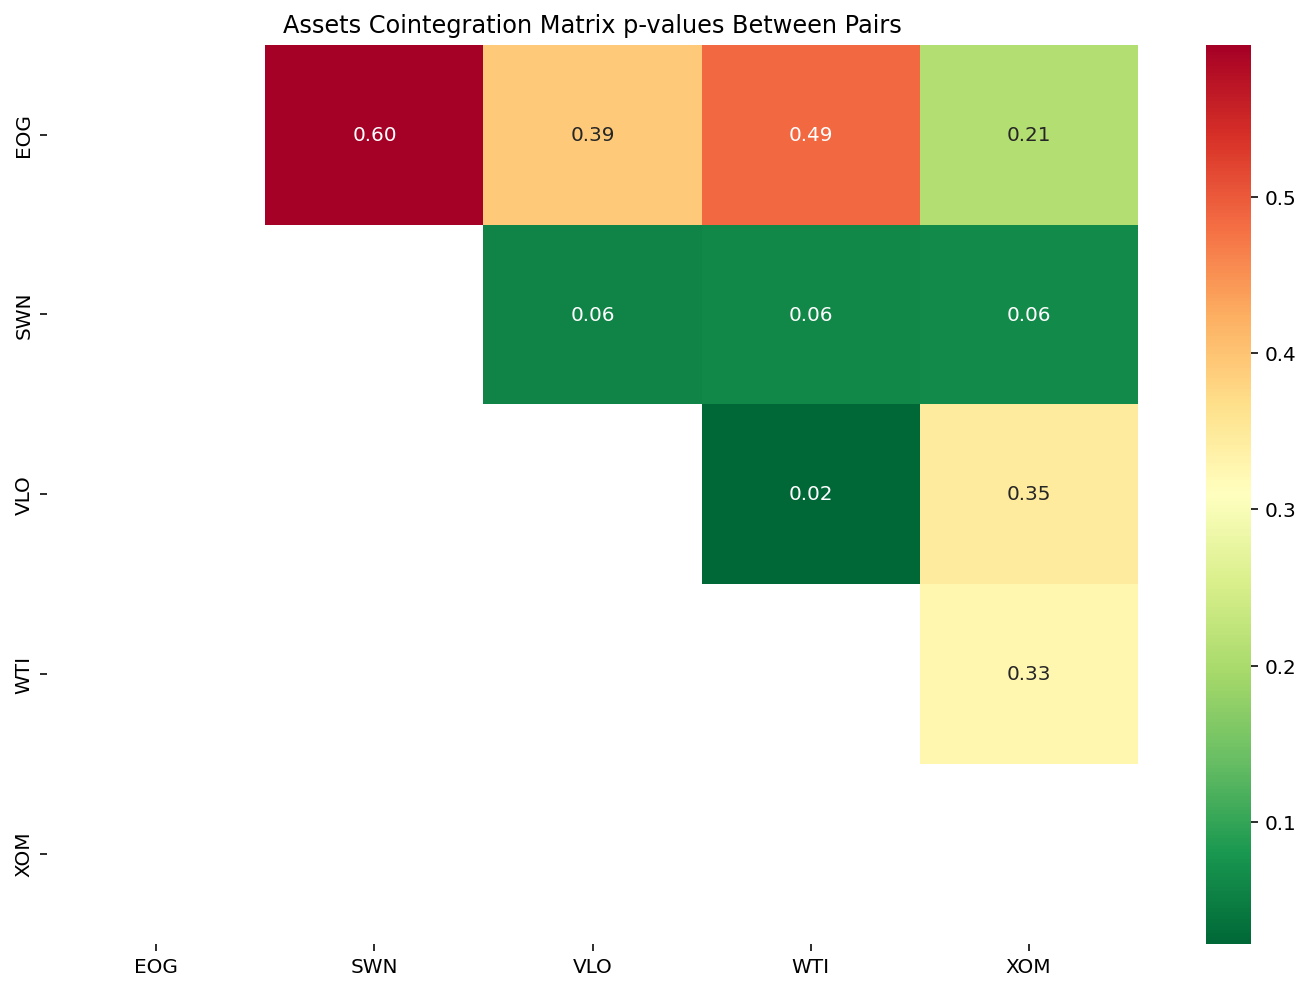

In [42]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = df.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
#plt.savefig('images/chart2', dpi=300) 

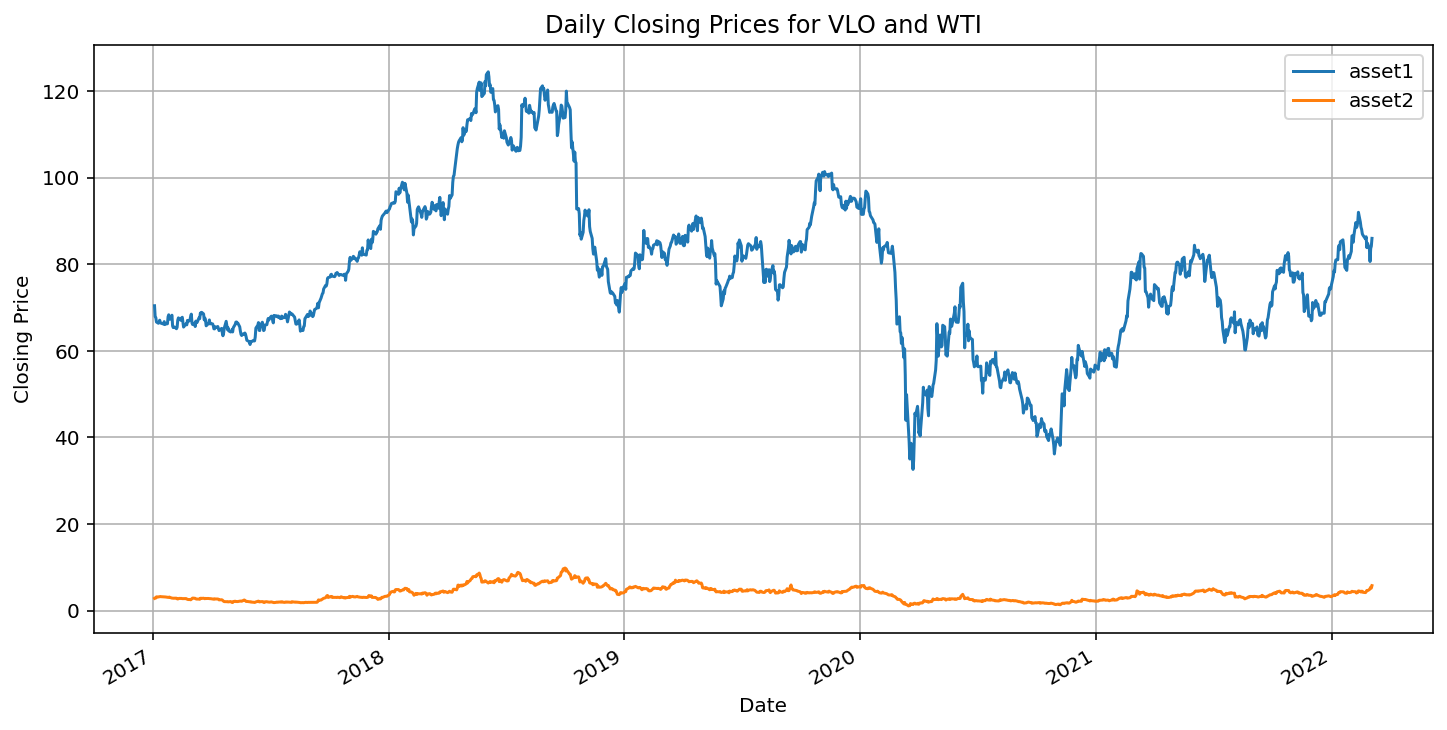

In [43]:
# final pair to test strategy
asset1 = 'VLO'
asset2 = 'WTI'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
#plt.savefig('images/chart3', dpi=300) 

#S1 = sm.add_constant(S1)
#results = sm.OLS(S2, S1).fit()
#S1 = S1['DNNGY']
#b = results.params['DNNGY']

#spread = S2 - b * S1
#spread.plot(figsize=(12,6))
#plt.axhline(spread.mean(), color='black')
#plt.xlim('2018-09-01', '2022-01-01')
#plt.legend(['Spread']);

In [44]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

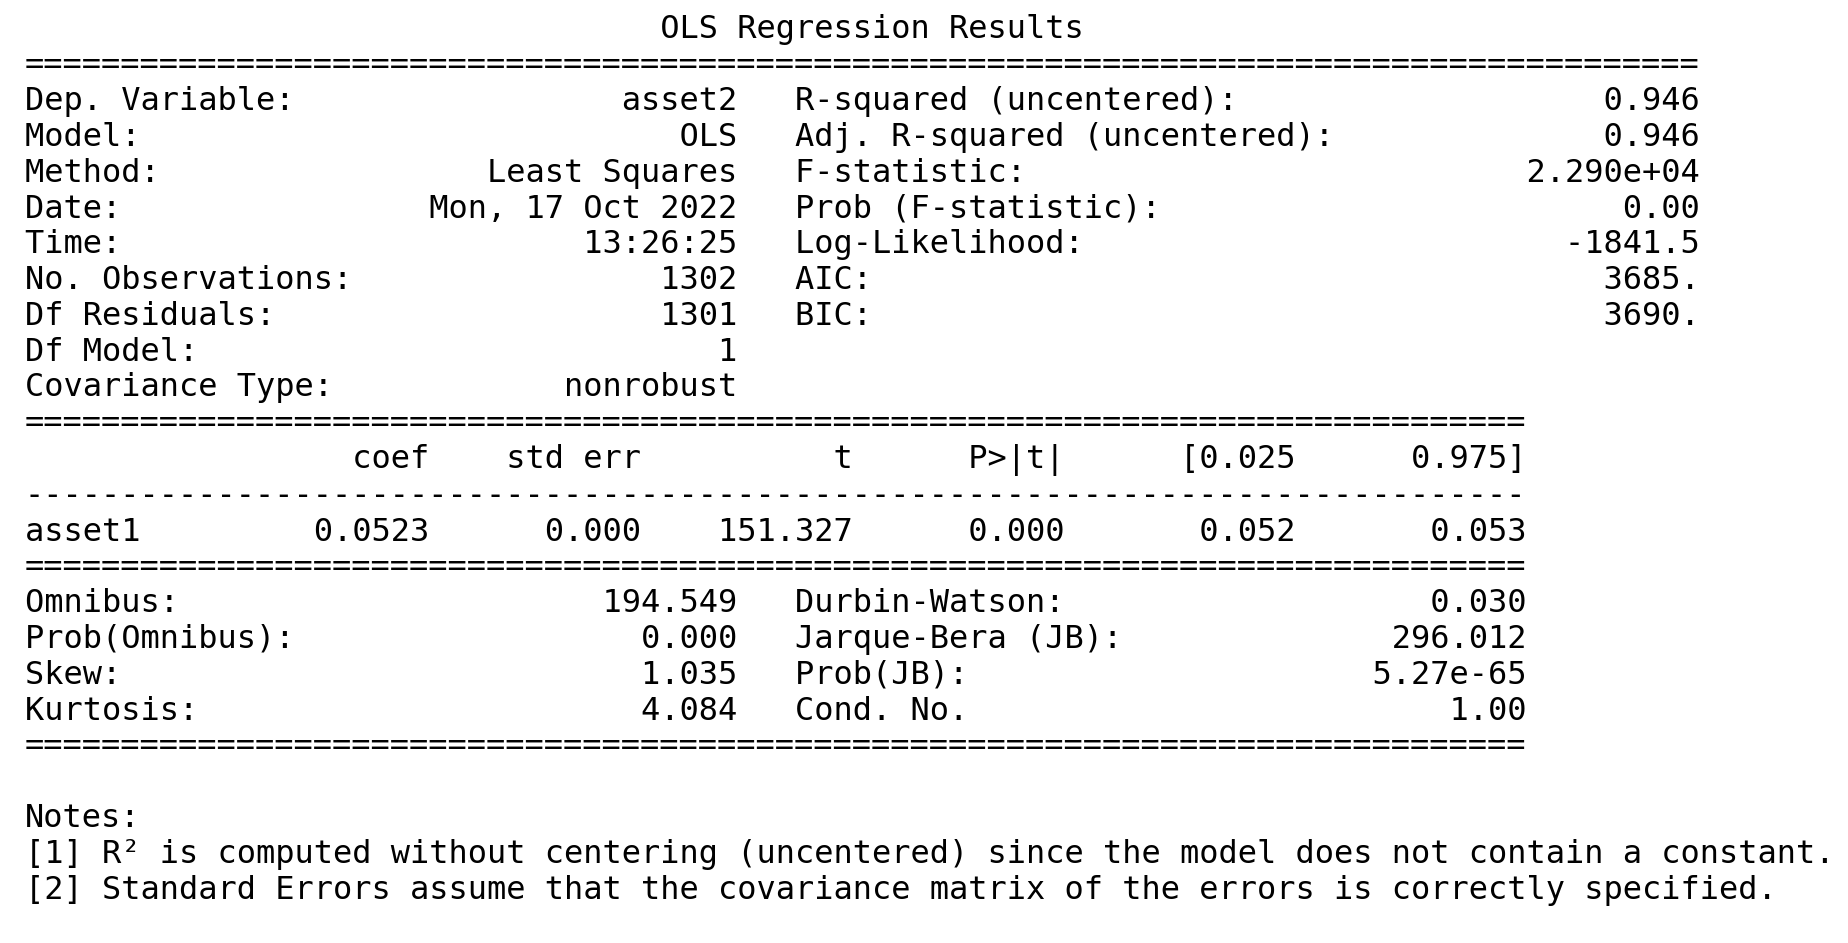

In [45]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

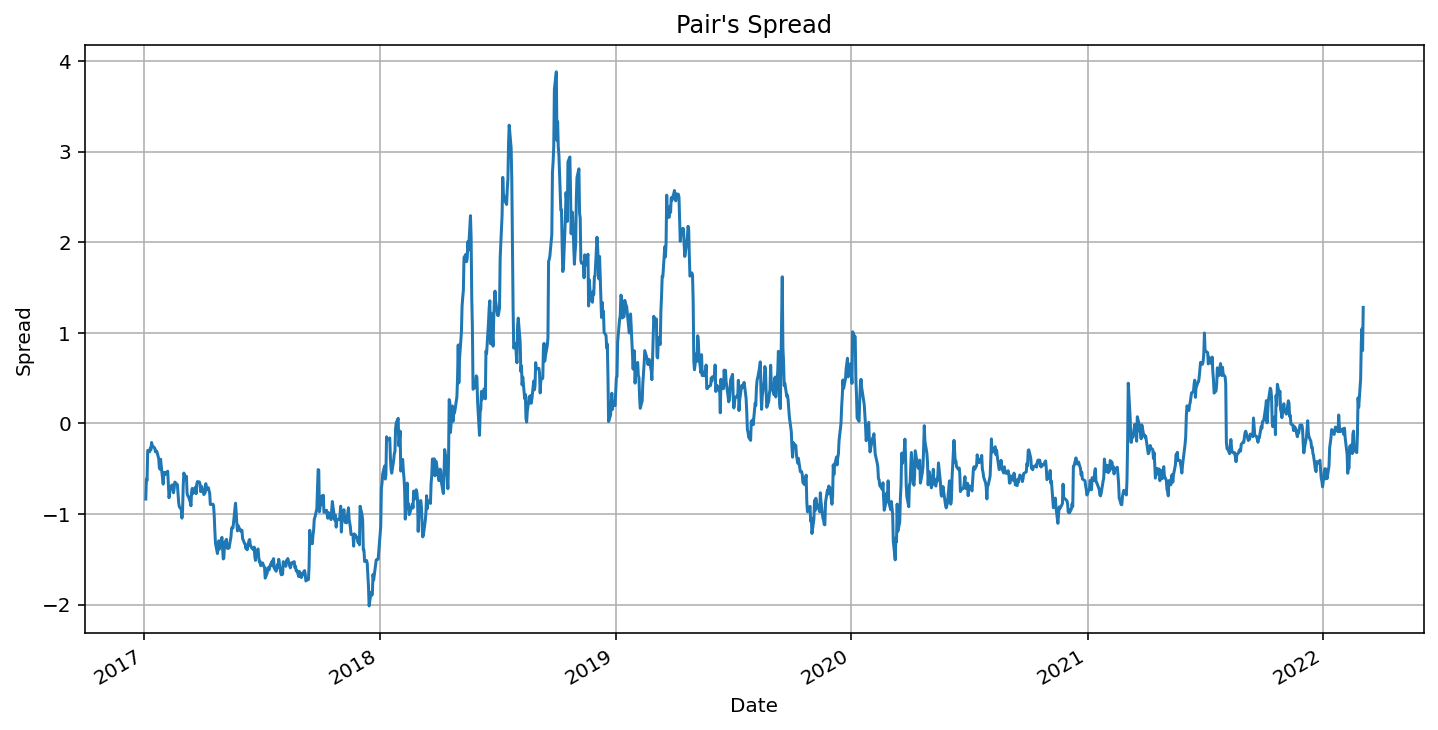

In [46]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

In [47]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.035257984248242


In [48]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

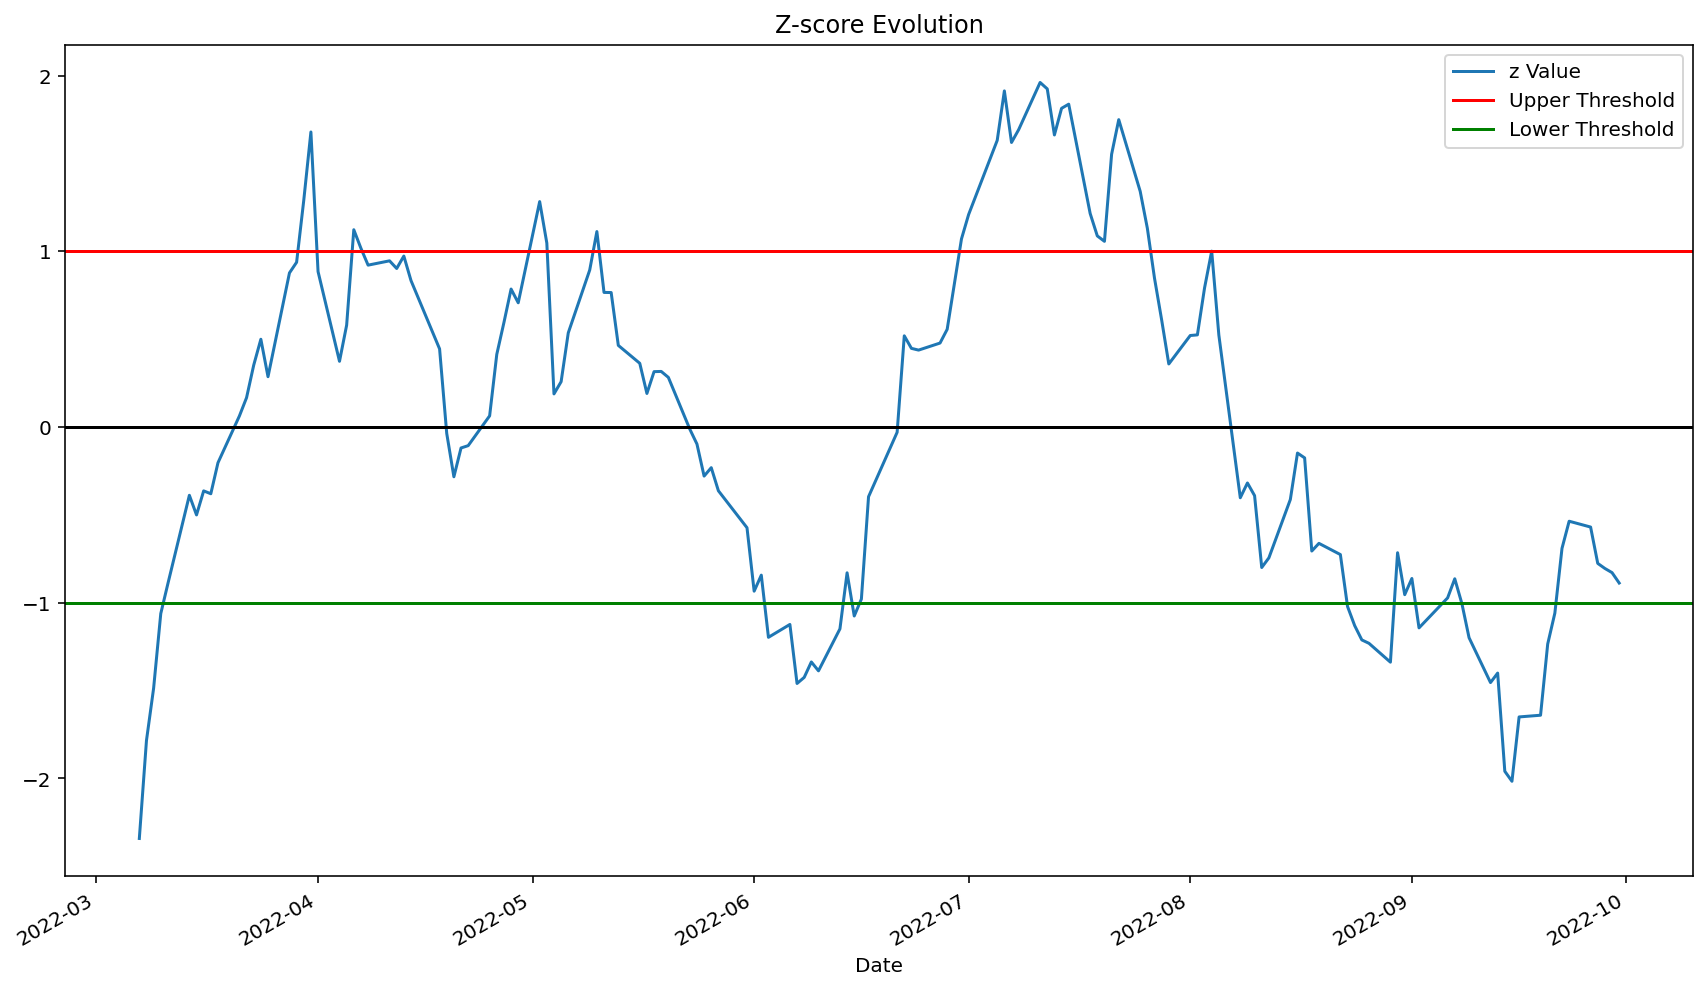

In [49]:
# visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evolution")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()

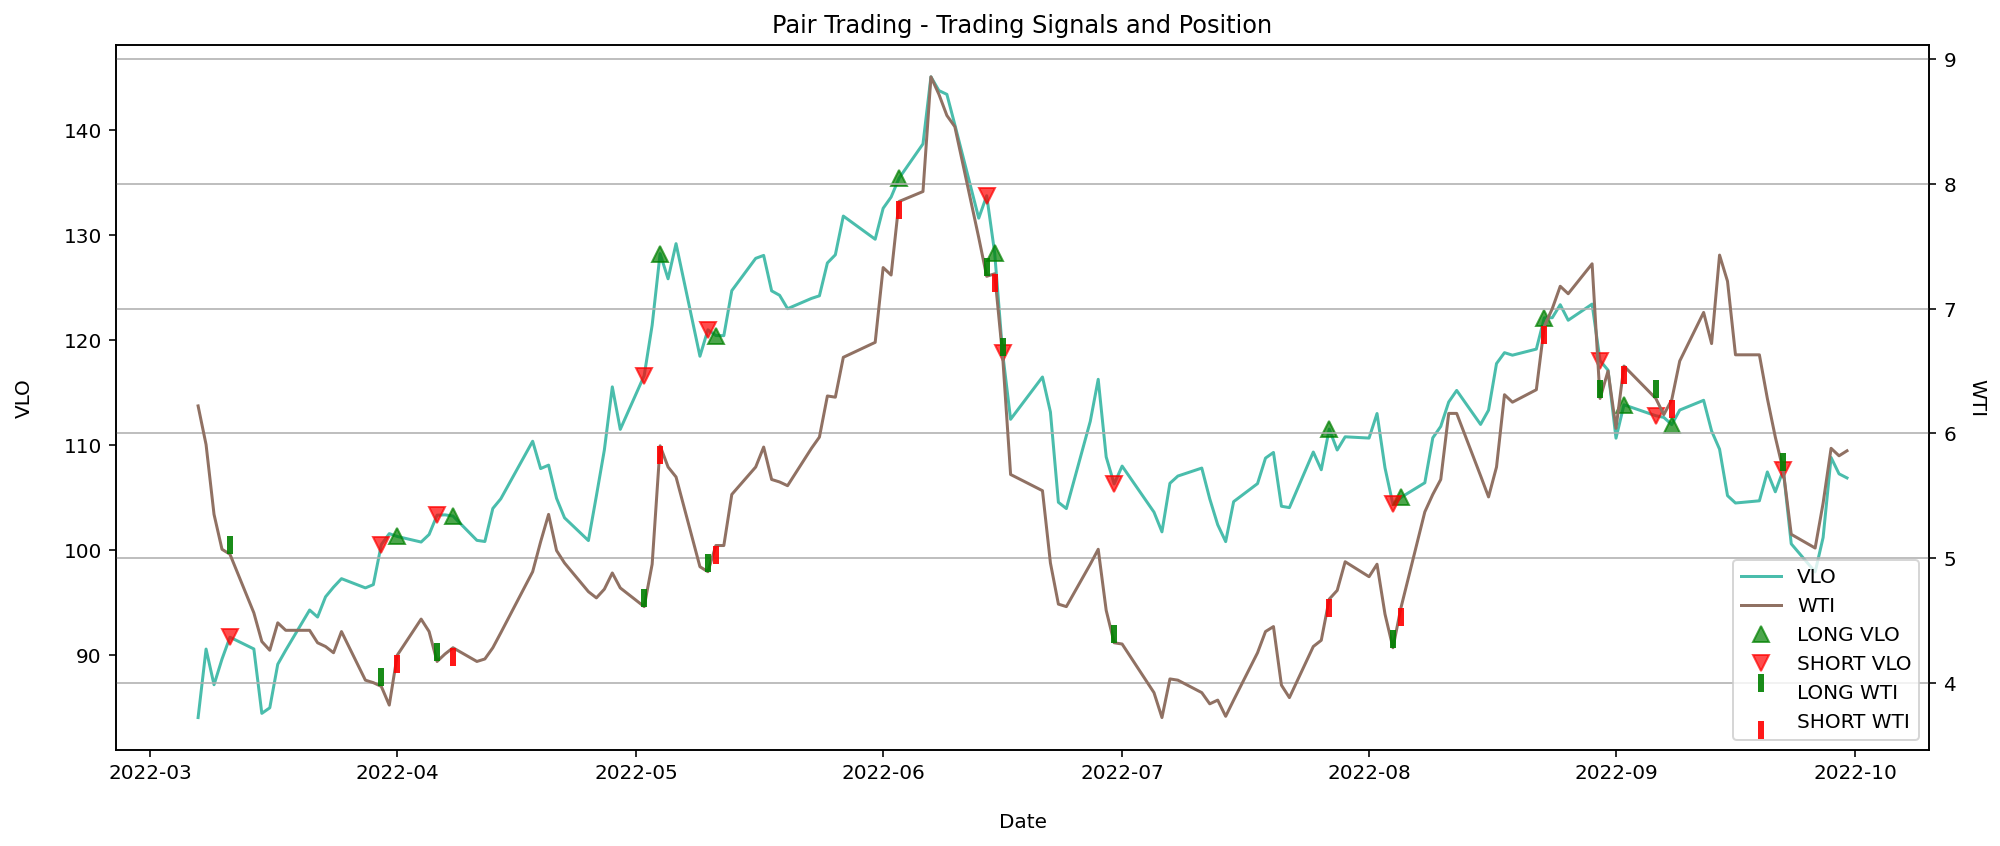

In [50]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='lower right')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()

### Portfolio Profit and Loss Calculation

In [51]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [52]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [54]:
portfolio[portfolio.positions1 != 0].head(20)

,asset1,holdings1,cash1,total asset1,return1,positions1
Date,,,,,,
2022-03-07,84.010002,NaN,NaN,NaN,NaN,NaN
2022-03-11,91.669998,-63160.628738,163160.628738,100000.000000,0.000000,-1.0
2022-03-30,100.500000,-138489.000000,232405.128738,93916.128738,-0.027261,-1.0
2022-04-01,101.269997,-69775.027687,162630.101051,92855.073364,0.004023,1.0
2022-04-06,103.300003,-142347.404205,233803.803154,91456.398949,-0.013672,-1.0
2022-04-08,103.220001,-71118.580841,162685.222313,91566.641472,0.001658,1.0
2022-05-02,116.599998,-160674.797897,243022.621262,82347.823364,-0.041079,-1.0
2022-05-04,128.229996,-88350.467056,154672.154205,66321.687149,-0.124274,1.0
2022-05-10,120.970001,-166696.661682,238020.485046,71323.823364,-0.023765,-1.0


In [55]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [57]:
portfolio[portfolio.positions2 != 0].head(20)

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2
Date,,,,,,,,,,,,
2022-03-07,84.010002,NaN,NaN,NaN,NaN,NaN,6.22,NaN,NaN,NaN,NaN,NaN
2022-03-11,91.669998,-63160.628738,163160.628738,100000.000000,0.000000,-1.0,5.03,56768.582368,43231.417632,100000.000000,0.000000,1.0
2022-03-30,100.500000,-138489.000000,232405.128738,93916.128738,-0.027261,-1.0,3.97,89610.840646,-1574.002691,88036.837955,-0.003831,1.0
2022-04-01,101.269997,-69775.027687,162630.101051,92855.073364,0.004023,1.0,4.22,47626.917632,46052.914941,93679.832573,0.106659,-1.0
2022-04-06,103.300003,-142347.404205,233803.803154,91456.398949,-0.013672,-1.0,4.17,94125.241722,-1009.705920,93115.535802,-0.028267,1.0
2022-04-08,103.220001,-71118.580841,162685.222313,91566.641472,0.001658,1.0,4.28,48304.082368,47294.376448,95598.458816,0.011947,-1.0
2022-05-02,116.599998,-160674.797897,243022.621262,82347.823364,-0.041079,-1.0,4.61,104056.923014,-4734.085059,99322.837955,-0.016759,1.0
2022-05-04,128.229996,-88350.467056,154672.154205,66321.687149,-0.124274,1.0,5.90,66587.401076,61853.316018,128440.717094,0.200411,-1.0
2022-05-10,120.970001,-166696.661682,238020.485046,71323.823364,-0.023765,-1.0,4.89,110377.076986,6664.777524,117041.854511,-0.003842,1.0


In [58]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

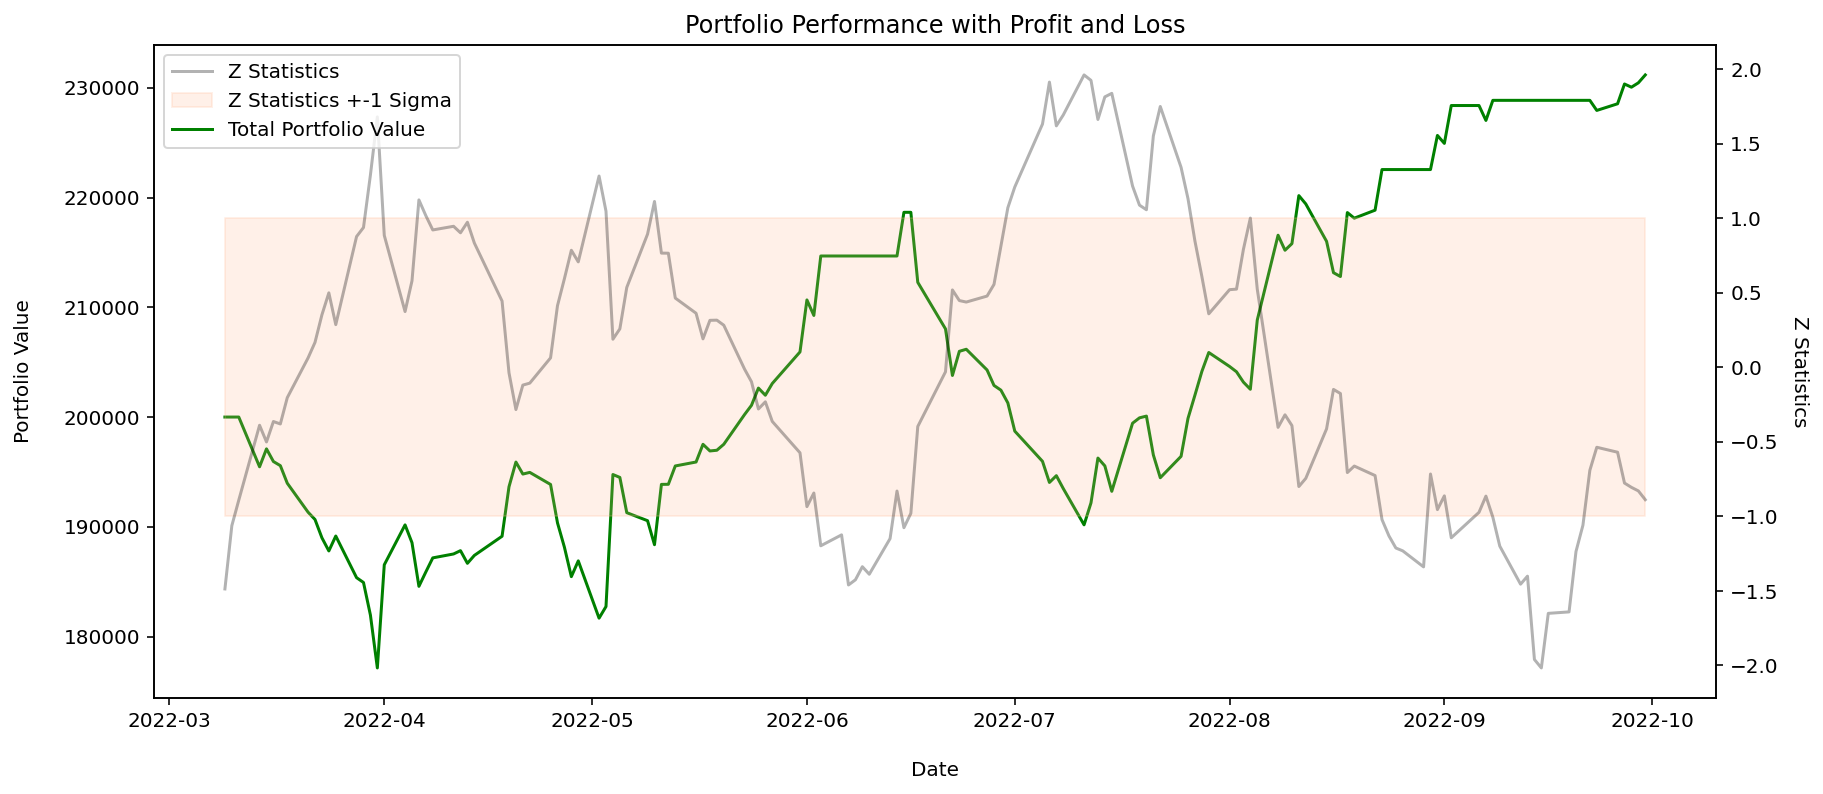

In [59]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');